In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "" #"1"
os.chdir("/nas/ucb/oliveradk/diverse-gen/")


In [2]:
import json
from functools import partial
from itertools import product
from typing import Optional, Literal, Callable
from tqdm import tqdm
from collections import defaultdict
from dataclasses import dataclass
from pathlib import Path
from copy import deepcopy
from datetime import datetime
from collections import defaultdict

import submitit
from submitit.core.utils import CommandFunction
import nevergrad as ng
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go

from losses.loss_types import LossType
from utils.exp_utils import get_executor, get_executor_local, run_experiments, get_conf_dir
from utils.proc_data_utils import get_exp_metrics, get_max_acc, get_acc_results

In [3]:
SCRIPT_NAME = "spur_corr_exp.py"
PARENT_DIR = Path("output/cc_mix_rate_schedule_sweep")
EXP_DIR_NAME = "2025-02-10_07-59-33"
if EXP_DIR_NAME is None:
    EXP_DIR_NAME = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
EXP_DIR = Path(PARENT_DIR, EXP_DIR_NAME)
EXP_DIR.mkdir(parents=True, exist_ok=True)
(EXP_DIR / "results").mkdir(parents=True, exist_ok=True)
(EXP_DIR / "figures").mkdir(parents=True, exist_ok=True)

# Define Configs

In [4]:
# seeds
SEEDS = [1, 2, 3]

# mix rates
MIX_RATES = [0.1, 0.25, 0.5, 0.75, 1.0]

# methods 
methods = {
    "TopK 0.1": {"loss_type": LossType.TOPK, "mix_rate_lower_bound": 0.1, "mix_rate_schedule": "linear", "binary": True}, 
    "TopK 0.5": {"loss_type": LossType.TOPK, "mix_rate_lower_bound": 0.5, "mix_rate_schedule": "linear", "binary": True}, 
}
# datasets 
datasets = {
    "toy_grid": {"dataset": "toy_grid", "model": "toy_model", "epochs": 100, "weight_decay": 1e-2, "batch_size": 32, "target_batch_size": 128, "plot_activations": False},
}

for dataset in datasets.values():
    dataset["mix_rate_t0"] = 0
    dataset["mix_rate_t1"] = dataset["epochs"]

# tuned according to total validatin loss
aux_weight_map = {
    "TopK 0.1": {
        "toy_grid": 1.0
    },
    "TopK 0.5": {
        "toy_grid": 1.0
    }
}

lr_optim_map = {
    "TopK 0.1": {
        "toy_grid": (1e-3, "sgd")
    }, 
    "TopK 0.5": {
        "toy_grid": (1e-3, "sgd")
    }
}

configs = {
    (ds_name, method_name, mix_rate, seed): {**ds, **method, "mix_rate": mix_rate, "seed": seed} 
    for (ds_name, ds), (method_name, method), mix_rate, seed in product(datasets.items(), methods.items(), MIX_RATES, SEEDS)
}

###  dataset x method adjustments
# aux weight
for ((ds_name, method_name, mix_rate, seed), conf) in configs.items():
    conf["aux_weight"] = aux_weight_map[method_name][ds_name]
# optimizer and lr
for ((ds_name, method_name, mix_rate, seed), conf) in configs.items():
    if method_name in lr_optim_map and ds_name in lr_optim_map[method_name]:
        conf["lr"], conf["optimizer"] = lr_optim_map[method_name][ds_name]

for conf in configs.values():
    if conf["loss_type"] == LossType.DBAT: 
        conf["batch_size"] = int(conf["batch_size"] / 2)
        conf["target_batch_size"] = int(conf["target_batch_size"] / 2)

def get_conf_dir(conf_name: tuple):
    ds, method, mix_rate, seed = conf_name
    return f"{EXP_DIR}/{ds}_{method}_{mix_rate}/{seed}"

for conf_name, conf in configs.items():
    conf["exp_dir"] = get_conf_dir(conf_name)
    conf["plot_activations"] = False


In [5]:
len(configs)

30

# Run Experiments

In [6]:
high_mem_ds = ["multi-nli", "celebA-0"]
low_mem_configs = {k: v for k, v in configs.items() if v["dataset"] not in high_mem_ds}
high_mem_configs = {k: v for k, v in configs.items() if v["dataset"] in high_mem_ds}


In [7]:
executor = get_executor(EXP_DIR, mem_gb=16)
jobs = run_experiments(executor, list(low_mem_configs.values()), SCRIPT_NAME)


In [8]:
executor = get_executor(EXP_DIR, mem_gb=32)
jobs = run_experiments(executor, list(high_mem_configs.values()), SCRIPT_NAME)                

# Process Results

In [7]:
# sort experiments
exps_by_dataset_method = defaultdict(lambda:defaultdict(list))
for (ds_name, method_name, mix_rate, seed), conf in configs.items():
    exps_by_dataset_method[ds_name][method_name].append(conf)

In [8]:
metrics_dict = defaultdict(list)
for (ds_name, method_name, mix_rate, seed), conf in configs.items():
    metrics_dict[(ds_name, method_name, mix_rate, seed)].append(get_exp_metrics(conf))

In [9]:
# get average accs (by val loss) for each experiment
acc_results = defaultdict(lambda:defaultdict(list))
for ds_name, method_dict in exps_by_dataset_method.items():
    for method_name, exps in method_dict.items():
        acc_results[ds_name][method_name] = get_acc_results(
            exps, model_selection="val_loss", acc_metric="test_acc", verbose=True, perf_source_acc=True
        )

In [10]:
# get average accs (by val loss) for each experiment
alt_acc_results = defaultdict(lambda:defaultdict(list))
for ds_name, method_dict in exps_by_dataset_method.items():
    for method_name, exps in method_dict.items():
        alt_acc_results[ds_name][method_name] = get_acc_results(
            exps, model_selection="val_loss", acc_metric="test_acc_alt", verbose=True, perf_source_acc=True
        )

In [11]:
# get average accs (by val loss) for each experiment
worst_acc_results = defaultdict(lambda:defaultdict(list))
for ds_name, method_dict in exps_by_dataset_method.items():
    for method_name, exps in method_dict.items():
        worst_acc_results[ds_name][method_name] = get_acc_results(
            exps, model_selection="val_loss", acc_metric="test_worst_acc", verbose=False, perf_source_acc=True
        )

## Plot Accuracy

In [12]:
FIGSIZE = (3., 2.5)
FONTSIZE = 12
TICK_FONTSIZE = 10

def plot_acc_results(
    results: dict, 
    ignored_loss_types: list[str]=[], 
    figsize: tuple[float, float]=FIGSIZE,
    ylim: tuple[float, float]=(0.5, 1.0), 
    title: Optional[str]=None, 
    fontsize: int=FONTSIZE,
    tick_fontsize: int=TICK_FONTSIZE,
    legend: bool=False, 
):
    # plot mean accuracy with dotted standard deviation for each method type at each mix rate
    fig, ax = plt.subplots(figsize=figsize)
    
    for loss_type, loss_results in results.items():
        if loss_type in ignored_loss_types:
            continue
        
        if isinstance(loss_type, LossType):
            loss_type = loss_type.name 
        
        if loss_type == LossType.ERM.name:
            results = [r for result in loss_results.values() for r in result]
            means = [np.mean(results) for _ in range(len(mix_rates))]
            stds = [np.std(results) for _ in range(len(mix_rates))]
            line_style = '--'
            marker = None
        else:
            means = [np.mean(loss_results[mix_rate]) for mix_rate in mix_rates]
            stds = [np.std(loss_results[mix_rate]) for mix_rate in mix_rates]
            line_style = '-'
            marker = 'o'
        
        
        ax.plot(mix_rates, means, label=loss_type, marker=marker, linestyle=line_style)
        ax.fill_between(mix_rates, 
                        [m - s for m, s in zip(means, stds)],
                        [m + s for m, s in zip(means, stds)],
                        alpha=0.2)

    # ax.set_xlabel('Mix Rate', fontsize=fontsize)
    # ax.set_ylabel('Accuracy', fontsize=fontsize)

    # set x ticks to mix rates
    x_labels = [str(mix_rate) for mix_rate in mix_rates]
    ax.set_xticks(mix_rates)
    ax.set_xticklabels(x_labels, fontsize=tick_fontsize)

    # tick fontsize
    ax.tick_params(axis='both', labelsize=tick_fontsize)


    if title is not None:
        ax.set_title(title, fontsize=fontsize)
    if legend:
        ax.legend()
    # ax.grid(True, linestyle='--', alpha=0.7)
    # start y axis at 0.75
    ax.set_ylim(*ylim)

    # remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # remove bottom and left spines
    # ax.spines['bottom'].set_visible(False)
    # ax.spines['left'].set_visible(False)

    fig.tight_layout()
    return fig, ax


In [13]:
def plot_acc_results_grid(
    results_dict: dict,
    nrows: int = 2,
    ncols: int = 3,
    ignored_loss_types: list[str] = [],
    figsize: tuple[float, float] = (9, 6),
    ylim: tuple[float, float] = (0.5, 1.0),
    fontsize: int = FONTSIZE,
    tick_fontsize: int = TICK_FONTSIZE,
    xlabel: str = "Mix Rate",
    ylabel: str = "Accuracy",
    dataset_titles: dict[str, str] = {},
):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    
    for idx, (ds_name, method_dict) in enumerate(results_dict.items()):
        ax = axes[idx]
        
        for loss_type, loss_results in method_dict.items():
            if loss_type in ignored_loss_types:
                continue
            
            if isinstance(loss_type, LossType):
                loss_type = loss_type.name 
            
            if loss_type == LossType.ERM.name:
                results = [r for result in loss_results.values() for r in result]
                means = [np.mean(results) for _ in range(len(MIX_RATES))]
                stds = [np.std(results) for _ in range(len(MIX_RATES))]
                line_style = '--'
                marker = None
            else:
                means = [np.mean(loss_results[mix_rate]) for mix_rate in MIX_RATES]
                stds = [np.std(loss_results[mix_rate]) for mix_rate in MIX_RATES]
                line_style = '-'
                marker = 'o'
            
            ax.plot(MIX_RATES, means, label=loss_type, marker=marker, linestyle=line_style)
            ax.fill_between(MIX_RATES, 
                          [m - s for m, s in zip(means, stds)],
                          [m + s for m, s in zip(means, stds)],
                          alpha=0.2)

        x_labels = [str(mix_rate) for mix_rate in MIX_RATES]
        ax.set_xticks(MIX_RATES)
        ax.set_xticklabels(x_labels, fontsize=tick_fontsize)
        ax.tick_params(axis='both', labelsize=tick_fontsize)
        title = dataset_titles.get(ds_name, ds_name) if dataset_titles else ds_name
        ax.set_title(title, fontsize=fontsize)
        ax.set_ylim(*ylim)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Add a single legend for the entire figure
    handles, labels = axes[0].get_lines(), [line.get_label() for line in axes[0].get_lines()]
    fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, 1.05), ncol=len(methods))

    fig.supxlabel(xlabel, fontsize=fontsize)
    fig.supylabel(ylabel, fontsize=fontsize)
    
    fig.tight_layout()
    return fig, axes

dataset_titles = {
    "toy_grid": "Toy Grid",
    "fmnist_mnist": "FMNIST+MNIST",
    "cifar_mnist": "CIFAR+MNIST",
    "waterbirds": "Waterbirds",
    "celebA-0": "CelebA",
    "multi-nli": "MultiNLI"
}

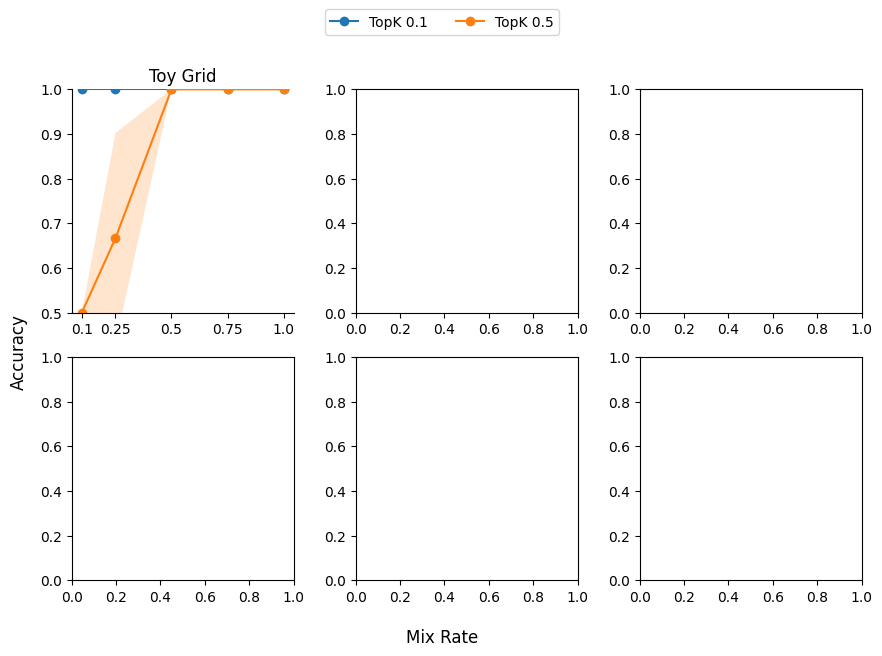

In [14]:
fig, axes = plot_acc_results_grid(acc_results, ignored_loss_types=[], dataset_titles=dataset_titles)
fig.savefig(f"{EXP_DIR}/figures/cc_mix_rate.svg", bbox_inches="tight", dpi=300)
plt.show()


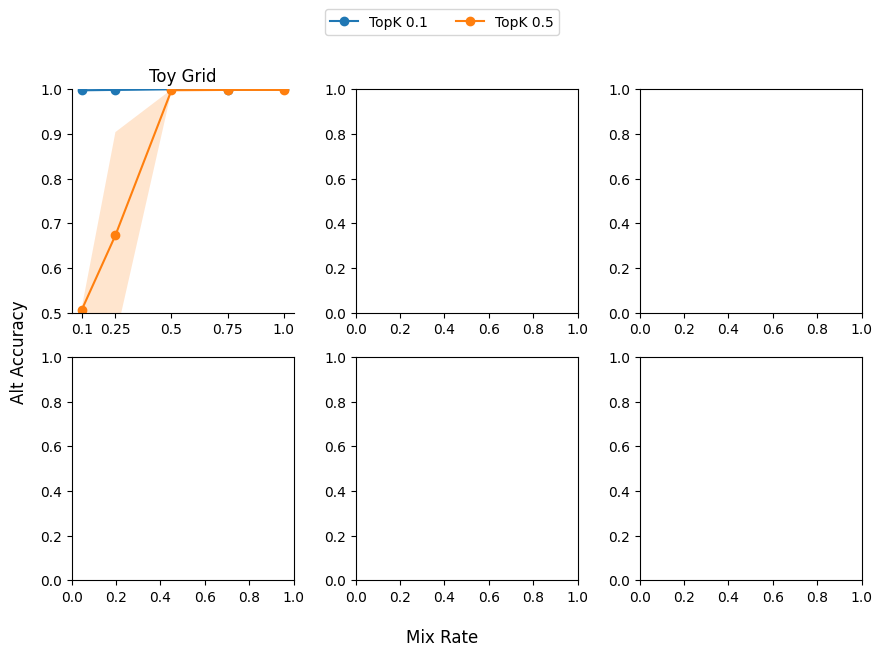

In [15]:

fig, axes = plot_acc_results_grid(alt_acc_results, ignored_loss_types=[], 
                      dataset_titles=dataset_titles, ylabel="Alt Accuracy")
fig.savefig(f"{EXP_DIR}/figures/cc_mix_rate_alt.svg", bbox_inches="tight", dpi=300)
plt.show()

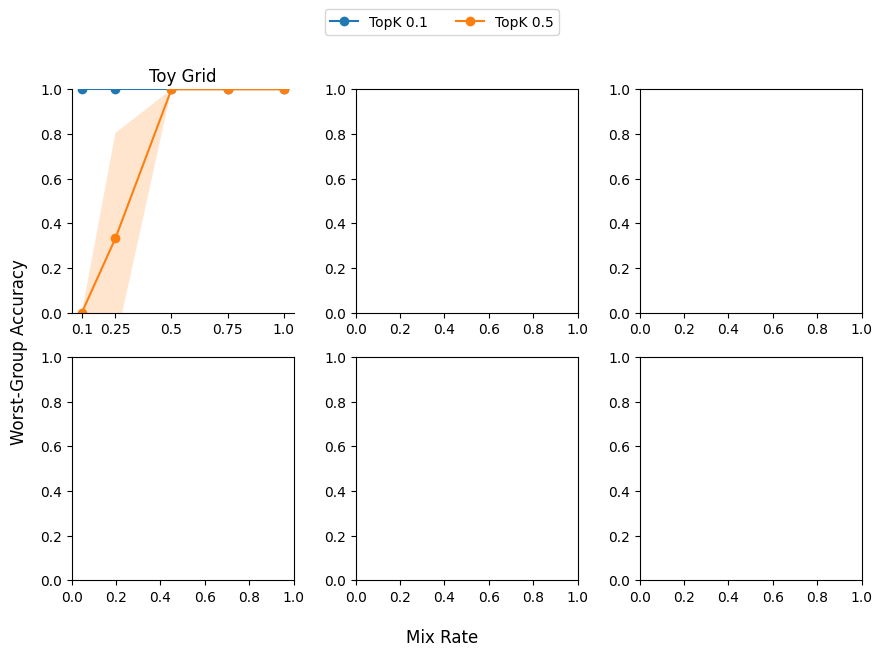

In [16]:

fig, axes = plot_acc_results_grid(worst_acc_results, 
                      ignored_loss_types=[], ylim=(0.0, 1.0), 
                      dataset_titles=dataset_titles, 
                      ylabel="Worst-Group Accuracy")

fig.savefig(f"{EXP_DIR}/figures/cc_mix_rate_worst.svg", bbox_inches="tight", dpi=300)
plt.show()


## Plot Aggregate Metrics Across Datasets 

# Correlation Between Val Loss and Test Acc

In [21]:
def plot_metric_correlations(configs, figsize=(15, 4), normalize=True, min_val_loss_only=False, mix_rate_color=False):
    # Group configs by method
    methods_configs = defaultdict(dict)
    for k, v in configs.items():
        method = k[1]  # Get method from config key
        methods_configs[method][k] = v
    
    # Create figure with subplots in one row
    n_methods = len(methods_configs)
    fig, axes = plt.subplots(1, n_methods, figsize=figsize)
    if n_methods == 1:
        axes = np.array([axes])
    
    # Process each method's data
    for idx, (method, method_configs) in enumerate(methods_configs.items()):
        # Collect metrics for this method
        all_metrics = []
        for conf in method_configs.values():
            metrics = get_exp_metrics(conf)
            if metrics is not None:
                # Get max accuracy between heads
                val_acc = np.array(metrics["val_target_acc_0"])
                if "val_target_acc_1" in metrics:
                    val_acc = np.max([val_acc, np.array(metrics["val_target_acc_1"])], axis=0)
                test_acc = np.array(metrics["test_acc_0"])
                if "test_acc_1" in metrics:
                    test_acc = np.max([test_acc, np.array(metrics["test_acc_1"])], axis=0)
                
                assert val_acc.shape == test_acc.shape
                
                if min_val_loss_only:
                    min_val_loss_idx = np.argmin(metrics["val_loss"])
                    all_metrics.append({
                        'val_loss': metrics["val_loss"][min_val_loss_idx],
                        'val_acc': val_acc[min_val_loss_idx],
                        'test_acc': test_acc[min_val_loss_idx],
                        'dataset': conf["dataset"],
                        'mix_rate': conf["mix_rate"]
                    })
                else:
                    for i in range(val_acc.shape[0]):
                        all_metrics.append({
                            'val_loss': metrics["val_loss"][i],
                            'val_acc': val_acc[i],
                            'test_acc': test_acc[i],
                            'dataset': conf["dataset"],
                            'mix_rate': conf["mix_rate"]
                        })
        
        df = pd.DataFrame(all_metrics)
        
        if normalize and not df.empty:
            for metric in ['val_loss', 'val_acc', 'test_acc']:
                groups = df.groupby(['dataset', 'mix_rate'])
                normalized = groups[metric].transform(lambda x: (x - x.mean()) / x.std())
                df[metric] = normalized
        
        if not df.empty:
            # Plot correlations
            ax = axes[idx]
            c = df['mix_rate'] if mix_rate_color else None
            cmap = 'viridis' if mix_rate_color else None
            scatter = ax.scatter(df['val_loss'], df['test_acc'], 
                               c=c, cmap=cmap, 
                               alpha=0.5)
            
            # Only add colorbar to last subplot
            if idx == n_methods - 1 and mix_rate_color:
                plt.colorbar(scatter, ax=ax, label='Mix Rate')
            
            # Only add y-label to first subplot
            if idx == 0:
                ax.set_ylabel('Test Accuracy (Normalized)' if normalize else 'Test Accuracy')
            
            # Add x-label to all subplots
            ax.set_xlabel('Validation Loss (Normalized)' if normalize else 'Validation Loss')
            
            r = np.corrcoef(df["val_loss"], df["test_acc"])[0,1]
            ax.set_title(f'{method}\nr={r:.3f}')
            
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            if normalize:
                ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
                ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    return fig, axes

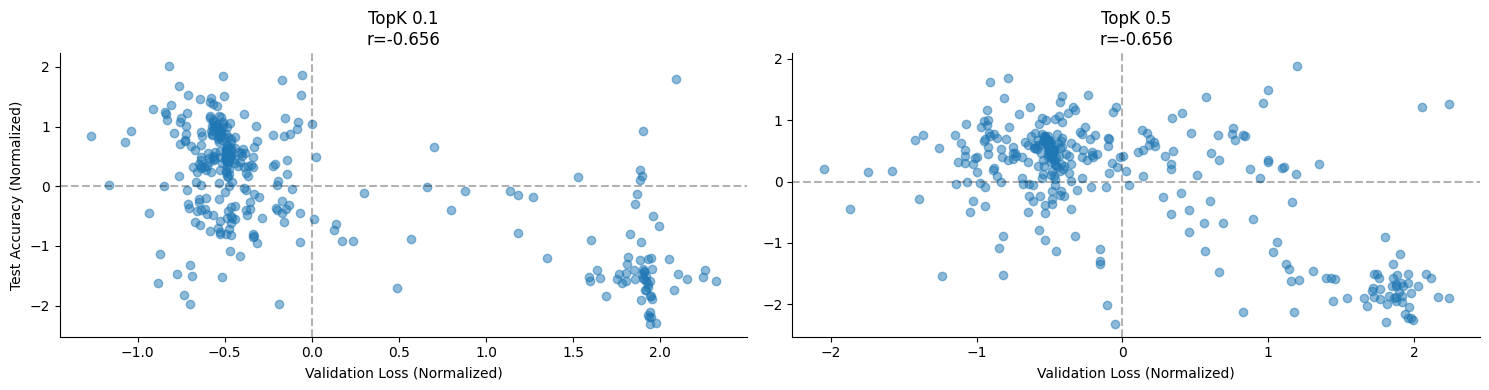

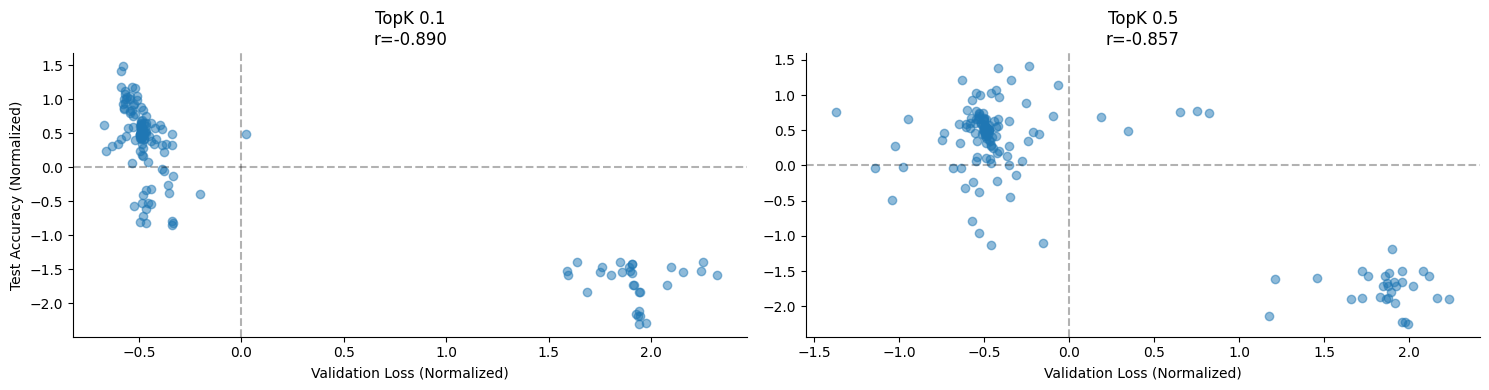

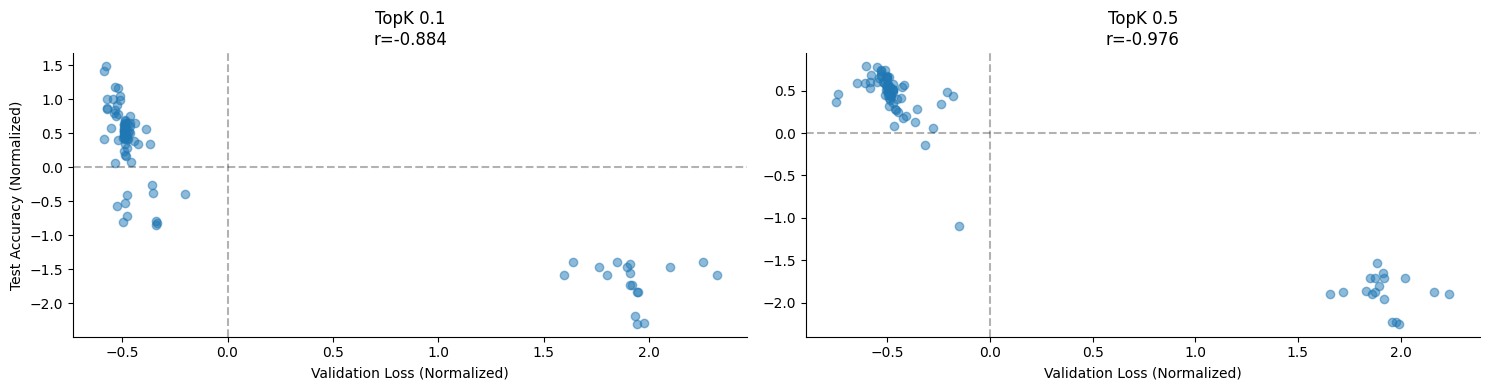

In [23]:
configs_to_plot = {k: v for k, v in configs.items() 
    if v["dataset"] != "toy_grid" and 
    v["loss_type"].name != "ERM"
}
fig, axes = plot_metric_correlations(configs_to_plot, normalize=True, min_val_loss_only=False)
fig.savefig(f"{EXP_DIR}/figures/cc_metric_correlations_all.svg", bbox_inches="tight", dpi=300)
plt.show()

configs_to_plot = {k: v for k, v in configs.items() 
    if v["dataset"] not in ["multi-nli", "celebA-0", "waterbirds", "toy_grid"] and 
    v["loss_type"].name != "ERM"
}
fig, axes = plot_metric_correlations(configs_to_plot, normalize=True, min_val_loss_only=False)
fig.savefig(f"{EXP_DIR}/figures/cc_metric_correlations_all_proportional.svg", bbox_inches="tight", dpi=300)
plt.show()

configs_to_plot = {k: v for k, v in configs.items() 
    if v["dataset"] not in ["multi-nli", "celebA-0", "waterbirds", "toy_grid"] 
    and v["mix_rate"] >= 0.5 and 
    v["loss_type"].name != "ERM"
}
fig, axes = plot_metric_correlations(configs_to_plot, normalize=True, min_val_loss_only=False)
fig.savefig(f"{EXP_DIR}/figures/cc_metric_correlations_all_proportional_mix_rate_0_5.svg", bbox_inches="tight", dpi=300)
plt.show()
